In [230]:
import numpy as np
from libero.libero.envs import OffScreenRenderEnv

class SequentialEnv(OffScreenRenderEnv):
    """
    For execute several policies in sequence in several envs
    """

    def __init__(self, n_tasks, **kwargs):
        # yy: note - in this class code, task == env

        self.n_tasks = n_tasks

        self.env_ls = []
        self.task_id = None
        self.complete_task = []
        for i in range(n_tasks):
            env_args = {
                "bddl_file_name": kwargs["bddl_file_name"][i],
                "camera_heights": kwargs["camera_heights"][i],
                "camera_widths": kwargs["camera_widths"][i],
            }
            env_instance = OffScreenRenderEnv(**env_args)  # Initialize the superclass with env_args
            self.env_ls.append(env_instance)
            
        self.keep_state = False
        self.state_to_keep = None

    def reset(self):
        self.task_id = 0
        return self.env_ls[0].reset()

    def seed(self, seed):
        seed = np.random.seed(seed)
        for env in self.env_ls:
            env.seed(seed)

    def set_init_state(self, init_states):
        return self.env_ls[self.task_id].set_init_state(init_states)

    def get_sim_state(self):
        return self.env_ls[self.task_id].sim.get_state().flatten()

    def step(self, action, enforce_move=False):
        obs, reward, done, info = self.env_ls[self.task_id].step(action)
        info['is_init'] = False
        if done or enforce_move:
            print(f"{done}!")
            self.complete_task.append(self.task_id)
            # yy: if current task_id is already the last one, do nothing
            # yy: auto initialize state for each new subtask - Note: still need to do this init for the 1st task manually
            if self.task_id != (self.n_tasks - 1):
                self.task_id += 1
                # self.set_init_state(self.init_states_ls[self.task_id])
                done = False
                info['is_init'] = True
                
                print("set new state for the next task env")
                crr_env_state = self.env_ls[self.task_id - 1].get_sim_state()
                self.env_ls[self.task_id].reset()
                self.env_ls[self.task_id].set_init_state(crr_env_state)
                
        info['task_index'] = self.task_id
        return obs, reward, done, info

    def close(self):
        for env in self.env_ls:
            env.close()


In [231]:
from libero.libero.envs import OffScreenRenderEnv
from PIL import Image
env_args = {
            "bddl_file_name": ["/home/yygx/UNC_Research/pkgs_simu/LIBERO/libero/libero/bddl_files/libero_90/KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet.bddl", "/home/yygx/UNC_Research/pkgs_simu/LIBERO/libero/libero/bddl_files/libero_90/KITCHEN_SCENE10_put_the_black_bowl_in_the_top_drawer_of_the_cabinet.bddl"],
            "camera_heights": [512, 512],
            "camera_widths": [512, 512],
        }

env = SequentialEnv(n_tasks=2, **env_args)
env.reset()

OrderedDict([('robot0_joint_pos',
              array([ 0.        , -0.16103739,  0.        , -2.44459747,  0.        ,
                      2.2267522 ,  0.78539816])),
             ('robot0_joint_pos_cos',
              array([ 1.        ,  0.98706148,  1.        , -0.76677449,  1.        ,
                     -0.60991702,  0.70710678])),
             ('robot0_joint_pos_sin',
              array([ 0.        , -0.16034226,  0.        , -0.64191657,  0.        ,
                      0.79246529,  0.70710678])),
             ('robot0_joint_vel', array([0., 0., 0., 0., 0., 0., 0.])),
             ('robot0_eef_pos',
              array([-0.20846466,  0.        ,  1.17327948])),
             ('robot0_eef_quat',
              array([ 9.99596605e-01,  2.46212832e-04, -2.84001205e-02, -6.99529596e-06])),
             ('robot0_gripper_qpos', array([ 0.020833, -0.020833])),
             ('robot0_gripper_qvel', array([0., 0.])),
             ('agentview_image',
              array([[[201, 184, 

In [232]:
initial_state = env.get_sim_state()
a = env.get_sim_state()

In [233]:
import torch
init_states_push_drawer = torch.load("/home/yygx/UNC_Research/pkgs_simu/LIBERO/libero/libero/init_files/libero_90/KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet.pruned_init")
init_states_put_bowl = torch.load("/home/yygx/UNC_Research/pkgs_simu/LIBERO/libero/libero/init_files/libero_90/KITCHEN_SCENE10_put_the_black_bowl_in_the_top_drawer_of_the_cabinet.pruned_init")

{'is_init': False, 'task_index': 0}
True!
set new state for the next task env
{'is_init': True, 'task_index': 1}


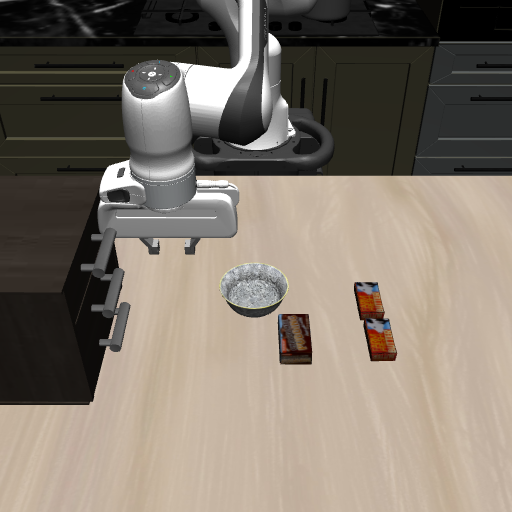

In [278]:
env.reset()
action = np.array([20, 10, -10, 0., 0., 0, 0])
for _ in range(10):
    obs, reward, done, info = env.step(action)
print(info)
action = np.array([0, -10, 0, 0., 0., 0, 0])
for _ in range(24):
    obs, reward, done, info = env.step(action)
print(info)
# action = np.array([0, 10, 0, 0., 0., 0, 0])
# for _ in range(5):
#     obs, reward, done, info = env.step(action)
# print(info)
b = env.get_sim_state()
display(Image.fromarray(obs["agentview_image"][::-1]))

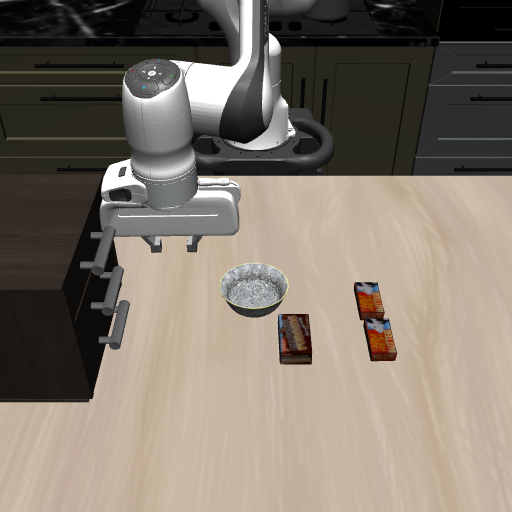

(None, False, {'is_init': False, 'task_index': 1})

In [279]:
# env.task_id = 1
obs, reward, done, info = env.step(np.array([0, 0, 0, 0., 0., 0, 0]))
display(Image.fromarray(obs["agentview_image"][::-1])), done, info

In [280]:
env.task_id

1

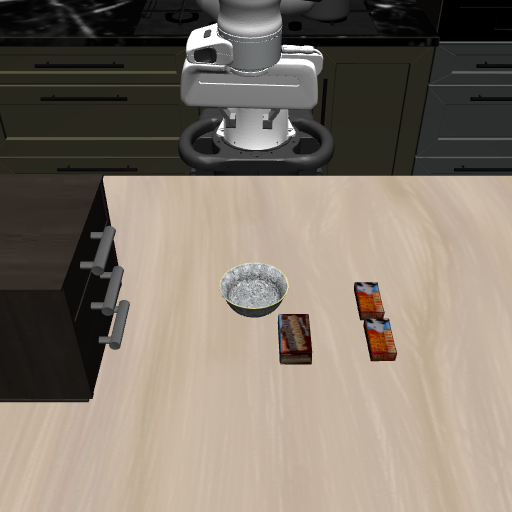

In [281]:
crr_state = env.get_sim_state()
crr_state[1:10] = init_states_put_bowl[0][1:10]
# zeroize all velocity related states
crr_state[41:] = init_states_put_bowl[0][41:]
obs = env.set_init_state(crr_state)
display(Image.fromarray(obs["agentview_image"][::-1]))

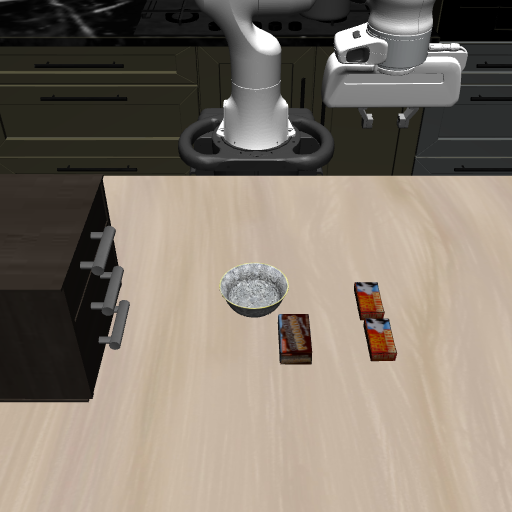

(None, False, {'is_init': False, 'task_index': 1})

In [298]:
# env.task_id = 1
obs, reward, done, info = env.step(np.array([0, 10, 0, 0., 0., 0, 0]))
display(Image.fromarray(obs["agentview_image"][::-1])), done, info